# MOVIE RECOMMENDATION SYSTEM

## Context
In this project, I build three recommendation systems:


*   Nonpersonalized recommendations
*   Content-based recommendations
* Collaborative filtering



## Data Understanding
The datasets considered here are the [MovieLens dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset).
The data considered are contained in two files.
1. **rating.csv** that contains ratings of movies by users: userId, movieId, rating, timestamp
2. **movie.csv** that contains movie information: movieId, title, genres



In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Read the csv files
rating = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/data/rating.csv') 
movie = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/data/movie.csv')

Let us explore the datasets.

## Describe data

Let us start with the movie dataset

### Movie dataset

In [4]:
movie.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [5]:
movie.shape

(27278, 3)

In [6]:
movie.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [7]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [8]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movie.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

Since the title column has year on it, we remove the year from title column and generate year column.

In [10]:
movie['year'] = movie.title.str.extract('(\(\d\d\d\d\))',expand=False)
# Remove the parentheses
movie['year'] = movie.year.str.extract('(\d\d\d\d)',expand=False)

In [11]:
# Remove the years from the 'title' column
movie['title'] = movie.title.str.replace('(\(\d\d\d\d\))', '')
# Apply the strip function to get rid of any ending whitespace characters that may have appeared
movie['title'] = movie['title'].str.strip()
movie.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [12]:
movie.isnull().sum()

movieId     0
title       0
genres      0
year       22
dtype: int64

Since there are 22 missing values for the year column, let us drop their corresponding rows.

In [13]:
movie['year'] = pd.to_numeric(movie['year'], errors='coerce')
movie = movie.dropna()
movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27256 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27256 non-null  int64  
 1   title    27256 non-null  object 
 2   genres   27256 non-null  object 
 3   year     27256 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.0+ MB


### Rating dataset

Let us explore the rating dataset.

In [14]:
rating.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [15]:
rating.shape

(20000263, 4)

In [16]:
rating.dtypes

userId         int64
movieId        int64
rating       float64
timestamp     object
dtype: object

In [17]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [18]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [19]:
rating.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

We convert the datatype of timestamp column to datetime.

In [20]:
rating['timestamp'] = rating['timestamp'].apply(pd.to_datetime)

In [21]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 610.4 MB


## Data Exploration

**How many movies were released per year?**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


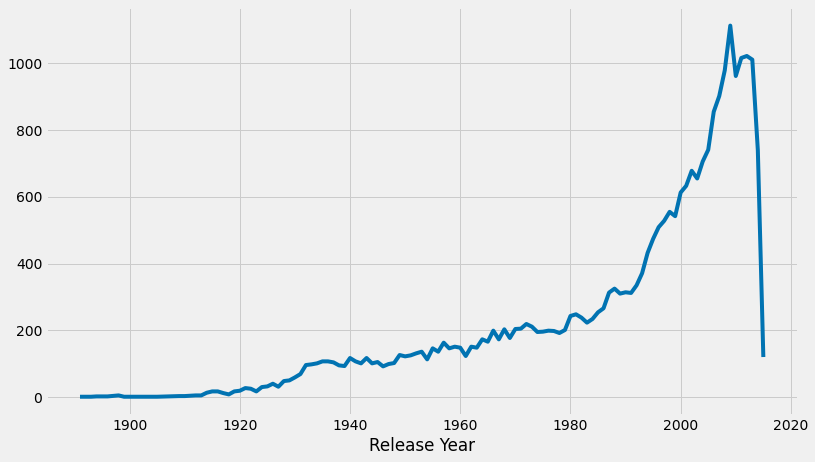

In [22]:
plt.style.use('fivethirtyeight')
sns.set_palette("colorblind")
plt.figure(figsize=(12,7))
yearly_release_counts = movie.groupby(movie.year).size().sort_values(ascending=False)
sns.lineplot(yearly_release_counts.index, yearly_release_counts.values);
plt.xlabel('Release Year');

**How many movies were rated per year?**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


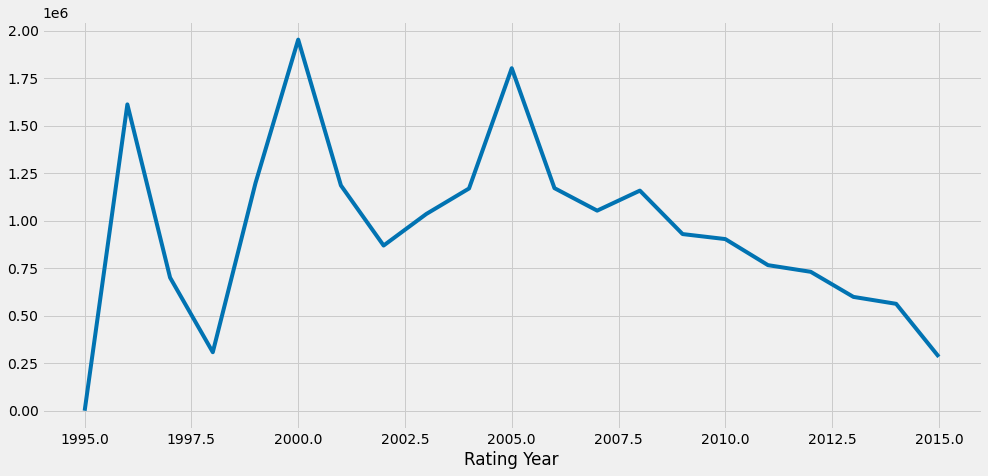

In [23]:
plt.style.use('fivethirtyeight')
sns.set_palette("colorblind")
plt.figure(figsize=(15,7))
yearly_rating_counts = rating.groupby(rating.timestamp.dt.year).size().sort_values(ascending=False)
sns.lineplot(yearly_rating_counts.index, yearly_rating_counts.values);
plt.xlabel('Rating Year');

**What are the genres of the movies?**

In [24]:
genre_df = movie['genres'].str.get_dummies()
movie_genre = pd.merge(movie, genre_df, left_on=None, right_on=None, left_index=True, right_index=True)
movie_genre = movie_genre.drop(columns=['genres', '(no genres listed)', 'movieId', 'IMAX'])
movie_genre.head()

,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Toy Story,1995.0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,Jumanji,1995.0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,1995.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,Waiting to Exhale,1995.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,Father of the Bride Part II,1995.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


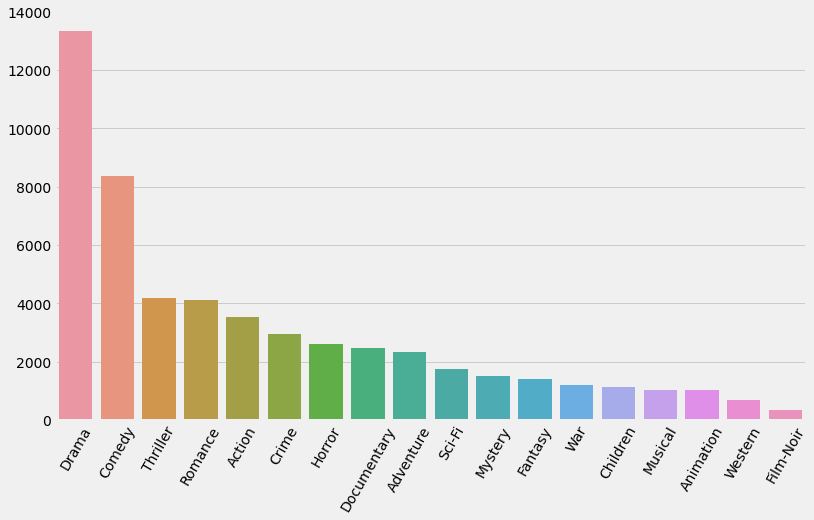

In [25]:
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 
           'Crime', 'Documentary','Drama', 'Fantasy', 'Film-Noir', 
           'Horror', 'Musical', 'Mystery','Romance', 'Sci-Fi', 
           'Thriller', 'War', 'Western']
plt.style.use('fivethirtyeight')
sns.set_palette("colorblind")
plt.figure(figsize=(12,7))
genre_counts = movie_genre.loc[:,genres].sum().sort_values(ascending=False)
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=60);

Next, we will merge the dataframes movie and rating to get more insights.

In [26]:
# Combine the two dataframes rating and movie into one dataframe movie_rating
movie_rating = pd.merge(rating,movie,on='movieId')
movie_rating.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,2,3.5,2005-04-02 23:53:47,Jumanji,Adventure|Children|Fantasy,1995.0
1,5,2,3.0,1996-12-25 15:26:09,Jumanji,Adventure|Children|Fantasy,1995.0
2,13,2,3.0,1996-11-27 08:19:02,Jumanji,Adventure|Children|Fantasy,1995.0
3,29,2,3.0,1996-06-23 20:36:14,Jumanji,Adventure|Children|Fantasy,1995.0
4,34,2,3.0,1996-10-28 13:29:44,Jumanji,Adventure|Children|Fantasy,1995.0


Let us look at the average rating of the movies.

In [27]:
avg_movie_rating = (movie_rating.
     groupby(by = ['title'])['rating'].
     mean().
     reset_index().
     rename(columns = {'rating': 'avg_movie_rating'})
     [['title', 'avg_movie_rating']]
    )
avg_movie_rating.head()

,title,avg_movie_rating
0,#chicagoGirl: The Social Network Takes on a Di...,3.666667
1,$ (Dollars),2.833333
2,$5 a Day,2.871795
3,$9.99,3.009091
4,$ellebrity (Sellebrity),2.000000


## Nonpersonalized recommendation

If we based on the average movie rating, we get the following movie recommendations.

In [28]:
# Sort the average moving rating in descending order and displaying the top 10.
avg_movie_rating = avg_movie_rating.sort_values(by='avg_movie_rating',ascending=False)
top_ten=avg_movie_rating.head(10)
top_ten

,title,avg_movie_rating
21015,Stargate SG-1 Children of the Gods - Final Cut,5.0
23592,"Turkish Dance, Ella Lola",5.0
12284,"Keeping the Promise (Sign of the Beaver, The)",5.0
15418,Muddy River,5.0
21234,"Story of Science, The",5.0
9043,Giorgino,5.0
8396,"Foster Brothers, The (Süt kardesler)",5.0
13389,Linotype: The Film,5.0
1778,B-Side,5.0
14440,Marihuana,5.0


As you can see, the titles are unfamiliar. Hence, we examine the number of ratings made for each of the movie.

In [29]:
# Create a new dataframe rating_count which consists the total rating count per movie
rating_count = (movie_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'total_rating_count'})
     [['title', 'total_rating_count']]
    )
rating_count['total_rating_count'].describe()

count    25696.000000
mean       778.325732
std       3162.483773
min          1.000000
25%          3.000000
50%         18.000000
75%        214.000000
max      67310.000000
Name: total_rating_count, dtype: float64

To make things easier, let us define a function that returns the rating coung of the top ten selected movies.

In [30]:
def ratingcount(i):
  print(rating_count.loc[i])

In [31]:
ratingcount(top_ten.index)

                                                title  total_rating_count
21015  Stargate SG-1 Children of the Gods - Final Cut                   1
23592                        Turkish Dance, Ella Lola                   1
12284   Keeping the Promise (Sign of the Beaver, The)                   1
15418                                     Muddy River                   1
21234                           Story of Science, The                   1
9043                                         Giorgino                   1
8396             Foster Brothers, The (Süt kardesler)                   1
13389                              Linotype: The Film                   1
1778                                           B-Side                   1
14440                                       Marihuana                   1


As you can see, each of the listed movie recommendations has received rating from only one user. This may not be accurate since we want a popular movies to be recommended for all the users. Hence, we set a popularity threshold, that is, we will only consider those movies who received ratings from 50 users and above.

From the movie_rating dataframe, we will create a new dataframe that consists the total rating count of the movie.

In [32]:
# Set the popularity threshold
popularity_threshold = 5000
popular_movie= rating_count.query('total_rating_count >= @popularity_threshold').reset_index(drop=True)
popular_movie.head()

,title,total_rating_count
0,(500) Days of Summer,5767
1,10 Things I Hate About You,11613
2,101 Dalmatians,8581
3,101 Dalmatians (One Hundred and One Dalmatians),7784
4,12 Angry Men,13304


In [33]:
print('The number of movies we will consider is ', popular_movie.shape[0],'.')

The number of movies we will consider is  1018 .


Next, we will merge the dataframes popular_movie and avg_movie_rating.

In [34]:
# Combine the two dataframes popular_movie and avg_movie_rating. into one dataframe df_nonpersonalized
df_nonpersonalized = pd.merge(popular_movie,avg_movie_rating,on='title', how='left')
df_nonpersonalized.head()

,title,total_rating_count,avg_movie_rating
0,(500) Days of Summer,5767,3.804231
1,10 Things I Hate About You,11613,3.473909
2,101 Dalmatians,8581,3.078429
3,101 Dalmatians (One Hundred and One Dalmatians),7784,3.432618
4,12 Angry Men,13304,4.213658


Our movie recommendations for all the user based on popularity is the following.

In [35]:
# Sort the df_nonpersonalized in descending order and displaying the top 10.
df_nonpersonalized = df_nonpersonalized.sort_values(by='avg_movie_rating',ascending=False)
df_nonpersonalized['title'].head(10).reset_index(drop=True)

0                 Shawshank Redemption, The
1                            Godfather, The
2                       Usual Suspects, The
3                          Schindler's List
4                   Godfather: Part II, The
5      Seven Samurai (Shichinin no samurai)
6                               Rear Window
7                                Casablanca
8    Sunset Blvd. (a.k.a. Sunset Boulevard)
9           One Flew Over the Cuckoo's Nest
Name: title, dtype: object

## Content-based recommendation

Let us build a recommendation system based on the genres of the movie. We will use the popular movie list from the nonpresonalized recommendation.

In [36]:
popular_movie_genre = pd.merge(popular_movie, movie_genre, how='left', on='title')

In [37]:
popular_movie_genre_table = pd.pivot_table(popular_movie_genre,index=['title'])
popular_movie_genre_table

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,total_rating_count,year
title,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5767,2009.0
10 Things I Hate About You,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11613,1999.0
101 Dalmatians,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8581,1996.0
101 Dalmatians (One Hundred and One Dalmatians),0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7784,1961.0
12 Angry Men,0.0,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13304,1977.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young Guns,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6755,1988.0
Zombieland,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5429,2009.0
Zoolander,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7499,2001.0


Next, we import libraries for our recommender system and define functions for our recommendation system.

We will use the jaccard metric.

In [38]:
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform

# Calculate all pairwise distances
jaccard_distances = pdist(popular_movie_genre_table.values, metric='jaccard')

# Convert the distances to a square matrix
jaccard_similarity_array = 1 -  squareform(jaccard_distances)

# Wrap the array in a pandas DataFrame
jaccard_similarity_df = pd.DataFrame(jaccard_similarity_array, 
                                     index=popular_movie_genre_table.index, 
                                     columns=popular_movie_genre_table.index)

In [39]:
def contentbased_jaccard(title):
  # Find the values for the movie title
  jaccard_similarity_series = jaccard_similarity_df.loc[title]
  # Sort these values from highest to lowest
  ordered_similarities = jaccard_similarity_series.sort_values(ascending=False)
  # Print the results
  print(ordered_similarities.head(10))

Now, we are ready for the content-based recommender system.

In [40]:
contentbased_jaccard('Wizard of Oz, The')

title
Wizard of Oz, The                                                                          1.000000
Charlie and the Chocolate Factory                                                          0.428571
NeverEnding Story, The                                                                     0.428571
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone)    0.428571
Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The                            0.428571
Jumanji                                                                                    0.428571
Indian in the Cupboard, The                                                                0.428571
Emperor's New Groove, The                                                                  0.375000
Honey, I Shrunk the Kids                                                                   0.375000
Monsters, Inc.                                                                             0.3

In [41]:
contentbased_jaccard("Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone)")

title
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone)    1.000000
Lord of the Rings: The Fellowship of the Ring, The                                         0.600000
Indian in the Cupboard, The                                                                0.600000
NeverEnding Story, The                                                                     0.600000
Jumanji                                                                                    0.600000
Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The                            0.600000
Monsters, Inc.                                                                             0.571429
Spirited Away (Sen to Chihiro no kamikakushi)                                              0.500000
Charlie and the Chocolate Factory                                                          0.500000
Shrek                                                                                      0.5

## Collaborative filtering

In [42]:
popular_movie.shape

(1018, 2)

In [43]:
rating.shape

(20000263, 4)

In [44]:
popular_movie_rating = pd.merge(popular_movie, movie_rating, on='title', how='left')

In [45]:
popular_movie_rating.shape

(13040777, 8)

In [46]:
popular_movie_rating.head()

,title,total_rating_count,userId,movieId,rating,timestamp,genres,year
0,(500) Days of Summer,5767,129,69757,5.0,2010-09-02 05:31:11,Comedy|Drama|Romance,2009.0
1,(500) Days of Summer,5767,133,69757,4.5,2014-04-11 16:42:38,Comedy|Drama|Romance,2009.0
2,(500) Days of Summer,5767,168,69757,3.0,2010-02-16 18:35:20,Comedy|Drama|Romance,2009.0
3,(500) Days of Summer,5767,190,69757,4.0,2012-02-12 19:14:29,Comedy|Drama|Romance,2009.0
4,(500) Days of Summer,5767,219,69757,4.5,2010-09-21 02:43:07,Comedy|Drama|Romance,2009.0


In [47]:
rating_crosstab = popular_movie_rating.pivot_table(values='rating', index='userId', columns='title', fill_value=0)
rating_crosstab.head()

title,(500) Days of Summer,10 Things I Hate About You,101 Dalmatians,101 Dalmatians (One Hundred and One Dalmatians),12 Angry Men,"13th Warrior, The","20,000 Leagues Under the Sea",2001: A Space Odyssey,21 Grams,28 Days Later,...,X-Men,X-Men: The Last Stand,X2: X-Men United,You've Got Mail,Young Frankenstein,Young Guns,Zombieland,Zoolander,eXistenZ,¡Three Amigos!
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,3.5,...,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
X = rating_crosstab.T
X.shape

(1018, 138488)

In [55]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=12, random_state=17)
resultant_matrix = SVD.fit_transform(X)
corr_mat = np.corrcoef(resultant_matrix)
movie_names = rating_crosstab.columns
movies_list = list(movie_names)

In [60]:
def collabfilter(title):
  movies = movies_list.index(title)
  corr_movie = corr_mat[movies]
  print(list(movie_names[(corr_movie<1.0) & (corr_movie> 0.90)]))

In [61]:
collabfilter('Wizard of Oz, The')

['Amadeus', 'American Graffiti', 'Arsenic and Old Lace', 'Birds, The', "Breakfast at Tiffany's", 'Casablanca', 'E.T. the Extra-Terrestrial', 'Fantasia', 'Gone with the Wind', 'Graduate, The', 'Grease', "It's a Wonderful Life", 'M*A*S*H (a.k.a. MASH)', 'Mary Poppins', 'Mr. Smith Goes to Washington', 'My Fair Lady', 'Philadelphia Story, The', 'Producers, The', 'Return of the Pink Panther, The', 'Roman Holiday', "Singin' in the Rain", 'Some Like It Hot', 'Sound of Music, The', 'To Kill a Mockingbird', 'Tootsie', 'West Side Story', 'Young Frankenstein']


In [62]:
collabfilter("Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone)")

['Bend It Like Beckham', "Bridget Jones's Diary", 'Charlie and the Chocolate Factory', "Charlie's Angels", 'Chicago', 'Chicken Run', 'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The', "Emperor's New Groove, The", 'Finding Nemo', 'Finding Neverland', 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Goblet of Fire', 'Harry Potter and the Prisoner of Azkaban', 'Ice Age', 'Incredibles, The', 'Legally Blonde', 'Lord of the Rings: The Fellowship of the Ring, The', 'Lord of the Rings: The Two Towers, The', 'Love Actually', 'Master and Commander: The Far Side of the World', 'Matrix Reloaded, The', 'Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2)', 'Minority Report', 'Monsters, Inc.', 'Moulin Rouge', 'My Big Fat Greek Wedding', "Ocean's Eleven", 'Pirates of the Caribbean: The Curse of the Black Pearl', 'School of Rock', 'Shrek', 'Shrek 2', 'Signs', 'Spider-Man', 'Spider-Man 2', 'Star Wars: Episode II - Attack of the Clones', 'Star Wars: Episode III - Revenge of the 